<a href="https://colab.research.google.com/github/wahid028/CryptoCurrency-Price-prediction_Kaggle/blob/main/EDA_03_g_research_crypto_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Connecting colab with kaggle using kaggle API**

In [7]:
#install kaggle
!pip install -q kaggle

In [8]:
#upload the kaggle.json file
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"learn2know","key":"ef7c1f3683ce0590f0cee38b88d74d21"}'}

In [9]:
#create a kaggle directory
!mkdir ~/.kaggle

In [10]:
#copy the kaggle.json to kaggle directory
!cp kaggle.json ~/.kaggle/

In [11]:
#permission for the json to act
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
#list all the available dataset in kaggle
!kaggle datasets list

ref                                                                   title                                                size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  --------------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                                 408KB  2022-04-03 09:25:39           8422       1139  0.9375           
victorsoeiro/netflix-tv-shows-and-movies                              Netflix TV Shows and Movies                           2MB  2022-05-15 00:01:23            868         37  0.9411765        
mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education       6KB  2022-04-16 04:46:28           5621        143  1.0              
muratkokludataset/rice-image-d

## **Get g-research-crypto-forecasting dataset**

In [13]:
!kaggle competitions download -c g-research-crypto-forecasting

100% 1.13G/1.13G [00:08<00:00, 143MB/s]
100% 1.13G/1.13G [00:08<00:00, 146MB/s]


In [14]:
#unzip the target file
!unzip g-research-crypto-forecasting.zip

Archive:  g-research-crypto-forecasting.zip
  inflating: asset_details.csv       
  inflating: example_sample_submission.csv  
  inflating: example_test.csv        
  inflating: gresearch_crypto/__init__.py  
  inflating: gresearch_crypto/competition.cpython-37m-x86_64-linux-gnu.so  
  inflating: supplemental_train.csv  
  inflating: train.csv               


## **EDA: Exploratory Data Analysis**

In [18]:
import pandas as pd
import numpy as np
pd.set_option("display.max_columns", None)

from datetime import datetime

import plotly.graph_objects as go
from plotly.subplots import make_subplots

import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})

from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

import warnings # Supress warnings
warnings.filterwarnings("ignore")

data_folder = "../content/"

asset_details = pd.read_csv(data_folder + 'asset_details.csv', low_memory=False)
train = pd.read_csv(data_folder + 'train.csv', low_memory=False)
#supplemental_train = pd.read_csv(data_folder + 'supplemental_train.csv', low_memory=False)
#example_test = pd.read_csv(data_folder + 'example_test.csv', low_memory=False)
#example_sample_submission = pd.read_csv(data_folder + 'example_sample_submission.csv', low_memory=False)

rename_dict = {}
for a in asset_details['Asset_ID']:
    rename_dict[a] = asset_details[asset_details.Asset_ID == a].Asset_Name.values[0]

#display(asset_details)

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



**Preprocessing**

For the following EDA, we will resample the minute-wise crypto data to daily samples. This reduces the amount of samples from 24,236,806 to 1,360.

In [19]:
# Convert timestamp
train['timestamp'] = train['timestamp'].astype('datetime64[s]')
#supplemental_train['timestamp'] = supplemental_train['timestamp'].astype('datetime64[s]')
#example_test['timestamp'] = example_test['timestamp'].astype('datetime64[s]')

#train['date'] = pd.DatetimeIndex(train['timestamp']).date
#supplemental_train['date'] = pd.DatetimeIndex(supplemental_train['timestamp']).date
#example_test['date'] = pd.DatetimeIndex(example_test['timestamp']).date

# Resample
train_daily = pd.DataFrame()

for asset_id in asset_details.Asset_ID:
    train_single = train[train.Asset_ID == asset_id].copy()

    train_single_new = train_single[['timestamp','Count']].resample('D', on='timestamp').sum()
    train_single_new['Open'] = train_single[['timestamp','Open']].resample('D', on='timestamp').first()['Open']
    train_single_new['High'] = train_single[['timestamp','High']].resample('D', on='timestamp').max()['High']
    train_single_new['Low'] = train_single[['timestamp','Low']].resample('D', on='timestamp').min()['Low']
    train_single_new['Close'] = train_single[['timestamp','Close']].resample('D', on='timestamp').last()['Close']
    train_single_new['Volume'] = train_single[['timestamp','Volume']].resample('D', on='timestamp').sum()['Volume']
    # train_single_new['VWAP']
    #train_single_new['Target'] = train_single[['timestamp','Target']].resample('D', on='timestamp').mean()['Target']
    train_single_new['Asset_ID'] = asset_id

    train_daily = train_daily.append(train_single_new.reset_index(drop=False))
train_daily = train_daily.sort_values(by = ['timestamp', 'Asset_ID']).reset_index(drop=True)

train_daily = train_daily.pivot(index='timestamp', columns='Asset_ID')[['Count', 'Open', 'High', 'Low', 'Close', 'Volume']]
train_daily = train_daily.reset_index(drop=False)

display(train_daily.head(5))

timestamp    Count                                                 \
Asset_ID                   0         1         2   3   4        5         6   
0        2018-01-01  18200.0  365257.0   59257.0 NaN NaN  13640.0  178492.0   
1        2018-01-02  29923.0  574564.0  114865.0 NaN NaN  26127.0  405855.0   
2        2018-01-03  24572.0  518239.0  104420.0 NaN NaN  25961.0  335488.0   
3        2018-01-04  26176.0  565945.0  100805.0 NaN NaN  46104.0  363372.0   
4        2018-01-05  44906.0  595440.0  114272.0 NaN NaN  24917.0  369258.0   

                                                        Open             \
Asset_ID        7   8         9  10       11  12  13       0          1   
0         35134.0 NaN  120933.0 NaN   8536.0 NaN NaN  8.5300  13835.194   
1         37735.0 NaN  247746.0 NaN  15632.0 NaN NaN  8.4500  13427.492   
2         26211.0 NaN  192320.0 NaN  13015.0 NaN NaN  8.7151  14748.296   
3         42602.0 NaN  230012.0 NaN  14636.0 NaN NaN  9.3040  15102.012   
4         34991.0 NaN  213587.0 NaN  14718.0 NaN NaN  9.1350  15154.766   

                                                                           \
Asset_ID            2   3   4       5         6        7   8        9  10   
0         2376.580000 NaN NaN  7.6596  738.3025  25.9200 NaN  225.330 NaN   
1         2320.886667 NaN NaN  7.6401  756.2250  29.4995 NaN  223.740 NaN   
2         2553.570000 NaN NaN  8.3205  860.1475  31.8710 NaN  251.220 NaN   
3         2558.480000 NaN NaN  9.4300  937.8450  33.1945 NaN  243.026 NaN   
4         2358.280000 NaN NaN  9.4704  942.9225  34.0655 NaN  237.534 NaN   

                             High                                             \
Asset_ID      11  12  13        0        1       2   3   4        5        6   
0         329.09 NaN NaN   8.7000  14442.9  2444.0 NaN NaN   7.9500   772.98   
1         340.35 NaN NaN   9.1133  15500.0  2745.5 NaN NaN   8.6000   899.50   
2         365.16 NaN NaN   9.4697  15599.7  2789.0 NaN NaN   9.4345   954.73   
3         385.03 NaN NaN   9.6511  15500.1  2577.1 NaN NaN  10.5030  1009.72   
4         372.50 NaN NaN  16.8172  17200.0  2530.9 NaN NaN   9.8500  1045.00   

                                                    Low                        \
Asset_ID      7   8       9  10      11  12  13       0         1       2   3   
0         32.50 NaN  237.77 NaN  348.30 NaN NaN  7.8000  12750.00  2241.3 NaN   
1         35.00 NaN  265.00 NaN  373.74 NaN NaN  8.0922  12798.00  2207.4 NaN   
2         33.79 NaN  261.49 NaN  390.00 NaN NaN  8.2653  14150.00  2501.0 NaN   
3         39.02 NaN  246.92 NaN  391.79 NaN NaN  8.5595  13918.04  2294.8 NaN   
4         36.00 NaN  260.00 NaN  388.00 NaN NaN  8.9651  14600.00  2282.0 NaN   

                                                                        Close  \
Asset_ID   4       5       6       7   8       9  10      11  12  13        0   
0        NaN  7.2000  716.80  25.034 NaN  212.74 NaN  316.06 NaN NaN   8.4500   
1        NaN  7.6220  749.06  29.120 NaN  222.62 NaN  320.00 NaN NaN   8.7150   
2        NaN  7.8343  810.00  29.831 NaN  233.56 NaN  359.01 NaN NaN   9.3040   
3        NaN  9.1500  890.01  30.499 NaN  219.38 NaN  352.29 NaN NaN   9.1430   
4        NaN  8.5079  900.00  30.333 NaN  230.00 NaN  340.03 NaN NaN  14.8908   

                                                                         \
Asset_ID          1            2   3   4       5         6        7   8   
0         13432.918  2321.520000 NaN NaN  7.6380  755.8725  29.4985 NaN   
1         14746.112  2555.440000 NaN NaN  8.2968  860.7650  31.8030 NaN   
2         15101.994  2553.175000 NaN NaN  9.4300  938.3775  33.2340 NaN   
3         15154.760  2358.246667 NaN NaN  9.4706  943.0325  34.0715 NaN   
4         16949.880  2388.633333 NaN NaN  9.2892  962.3350  31.1010 NaN   

                                            Volume                 \
Asset_ID        9  10       11  12  13           0              1   
0         224.108 NaN  341.17

**Data Overview**

Furthermore, we have samples from 2018-01-01 to 2021-09-21 for the majority of coins. For TRON, Stellar, Cardano, IOTA, Maker, and Dogecoin we have fewer data starting from later in 2018 or even later in 2019 in Dogecoin's case.

In [20]:
# Visualize
fig = make_subplots(
    rows=len(asset_details.Asset_ID), cols=1,
    subplot_titles=(asset_details.Asset_Name)
)

for i, asset_id in enumerate(asset_details.Asset_ID):
    fig.append_trace(go.Candlestick(x=train_daily.timestamp, 
                                         open=train_daily[('Open', asset_id)], 
                                         high=train_daily[('High', asset_id)], 
                                         low=train_daily[('Low', asset_id)], 
                                         close=train_daily[('Close', asset_id)]),
                  row=i+1, col=1,
                    )

    fig.update_xaxes(range=[train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]], row=i+1, col=1)


fig.update_layout(xaxis_rangeslider_visible = False, 
                  xaxis2_rangeslider_visible = False, 
                  xaxis3_rangeslider_visible = False,
                  xaxis4_rangeslider_visible = False,
                  xaxis5_rangeslider_visible = False,
                  xaxis6_rangeslider_visible = False,
                  xaxis7_rangeslider_visible = False,
                  xaxis8_rangeslider_visible = False,
                  xaxis9_rangeslider_visible = False,
                  xaxis10_rangeslider_visible = False,
                  xaxis11_rangeslider_visible = False,
                  xaxis12_rangeslider_visible = False,
                  xaxis13_rangeslider_visible = False,
                  xaxis14_rangeslider_visible = False,
                  height=3000, width=800, 
                  #title_text="Subplots with Annotations"
                      margin = dict(
        l = 0,
        r = 0,
        b = 0,
        t = 30,
        pad = 0)
                 )
                 
fig.show()

**Feature Engineering: Time Features**

In [21]:
train_daily['year'] = pd.DatetimeIndex(train_daily['timestamp']).year
train_daily['quarter'] = pd.DatetimeIndex(train_daily['timestamp']).quarter
train_daily['month'] = pd.DatetimeIndex(train_daily['timestamp']).month
train_daily['weekofyear'] = pd.DatetimeIndex(train_daily['timestamp']).weekofyear
train_daily['dayofyear'] = pd.DatetimeIndex(train_daily['timestamp']).dayofyear
train_daily['weekday'] = pd.DatetimeIndex(train_daily['timestamp']).weekday

**Feature Engineering: Log Return**

In [22]:
#To make a time series stationary, you can try differencing it. In this case, we will use the log return instead as shown below.
# define function to compute log returns
def log_return(series, periods=1):
    # Copied from https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition
    return np.log(series).diff(periods=periods)


for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('lret',  asset_id)] = log_return(train_daily[( 'Close',  asset_id)])

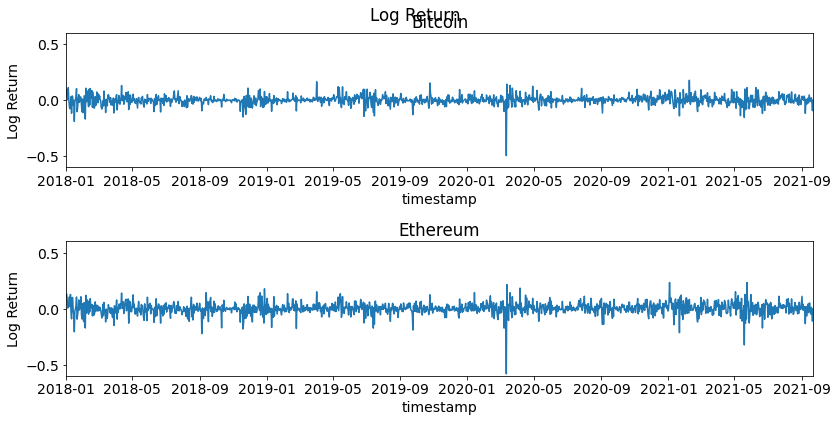

In [26]:
assets_mini = [1, 6]
# Visualize
f, ax = plt.subplots(nrows=len(assets_mini), ncols=1, figsize=(12, 6))
for i, asset_id in enumerate(assets_mini):

    sns.lineplot(data=train_daily, x='timestamp', y = ( 'lret',  asset_id) , ax=ax[i]);
    ax[i].set_title(asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0])
    ax[i].set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
    ax[i].set_ylim([-0.6,0.6])
    ax[i].set_ylabel('Log Return')
plt.suptitle('Log Return\n')

plt.tight_layout()
plt.show()

**COVID-19 Impact**

In the below plots for the log return, we can see a negative peak around March 2020. If we have a closer look at the log return of e.g. Bitcoin, we can see that this was the impact of the COVID-19 pandemic.

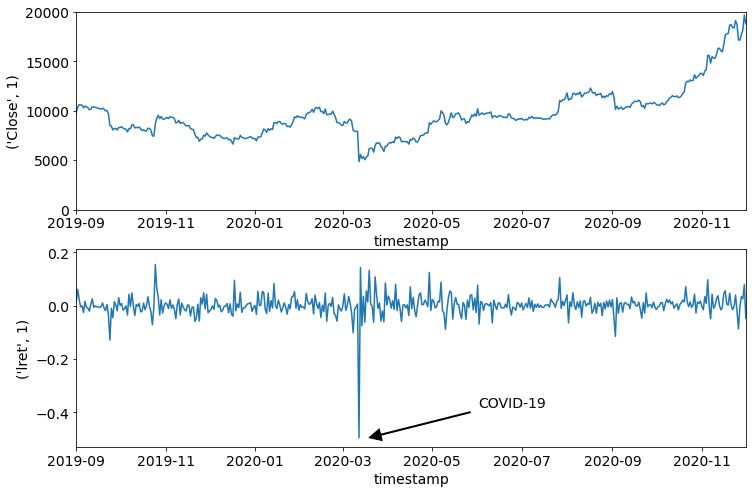

In [27]:
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

sns.lineplot(data=train_daily, x='timestamp', y = ( 'Close',  1) , ax=ax[0]);
sns.lineplot(data=train_daily, x='timestamp', y = ( 'lret',  1) , ax=ax[1]);
ax[0].set_xlim([pd.Timestamp('2019-09-01'), pd.Timestamp('2020-12-01')])
ax[0].set_ylim([0, 20000])

ax[1].set_xlim([pd.Timestamp('2019-09-01'), pd.Timestamp('2020-12-01')])
ax[1].annotate('COVID-19', xy=(pd.Timestamp('2020-03-15'), -0.5),  xycoords='data',
            xytext=(0.6, 0.2), textcoords='axes fraction',
            arrowprops=dict(facecolor='black', shrink=0.05, width=1),
            #horizontalalignment='right', verticalalignment='top',
            )
plt.show()

**Correlation**

In [28]:
# Visualize
fig = make_subplots(
    rows=2, cols=1,
    subplot_titles=(['Bitcoin', 'Ethereum'])
)

for i, asset_id in enumerate([1, 6]):
    fig.append_trace(go.Candlestick(x=train_daily.timestamp, 
                                         open=train_daily[('Open', asset_id)], 
                                         high=train_daily[('High', asset_id)], 
                                         low=train_daily[('Low', asset_id)], 
                                         close=train_daily[('Close', asset_id)]),
                  row=i+1, col=1,
                    )

    fig.update_xaxes(range=[pd.Timestamp('2018-01-01'), pd.Timestamp('2018-03-01')], row=i+1, col=1)

fig.update_yaxes(range=[0, 20000], row=1, col=1)
fig.update_yaxes(range=[0, 2000], row=2, col=1)

fig.update_layout(xaxis_rangeslider_visible = False, 
                  xaxis2_rangeslider_visible = False, 
                  #height=3000, 
                  width=800, 
                  #title_text="Subplots with Annotations"
                      margin = dict(
        l = 0,
        r = 0,
        b = 0,
        t = 30,
        pad = 0)
                 )
                 
fig.show()

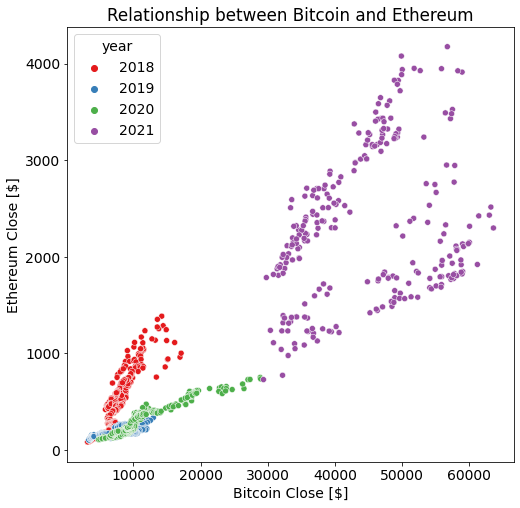

In [29]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 8))
sns.scatterplot(data=train_daily, x=('Close', 1), y=('Close', 6), hue='year', palette='Set1')
ax.set_xlabel('Bitcoin Close [$]')
ax.set_ylabel('Ethereum Close [$]')
ax.set_title('Relationship between Bitcoin and Ethereum')
plt.show()

**Feature Engineering: RatioGang**

In [30]:
train_daily['ratio_btc_etc'] = train_daily[( 'Close',  6)] / train_daily[( 'Close',  1)]

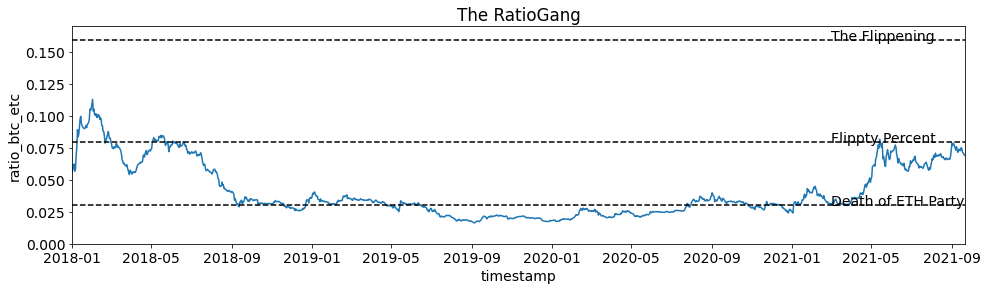

In [31]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 4))

sns.lineplot(data=train_daily, x='timestamp', y='ratio_btc_etc')
ax.axhline(y=0.03, color='k', linestyle='--')
ax.annotate('Death of ETH Party', xy=(pd.Timestamp('2021-03-01'), 0.03))

ax.axhline(y=0.07964, color='k', linestyle='--')
ax.annotate('Flippty Percent', xy=(pd.Timestamp('2021-03-01'), 0.07964))

ax.axhline(y=0.15929, color='k', linestyle='--')
ax.annotate('The Flippening', xy=(pd.Timestamp('2021-03-01'), 0.15929))

ax.set_ylim([0, 0.17])
ax.set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
ax.set_title('The RatioGang')
plt.show()

**Autocorrelation and Partial Autocorrelation**

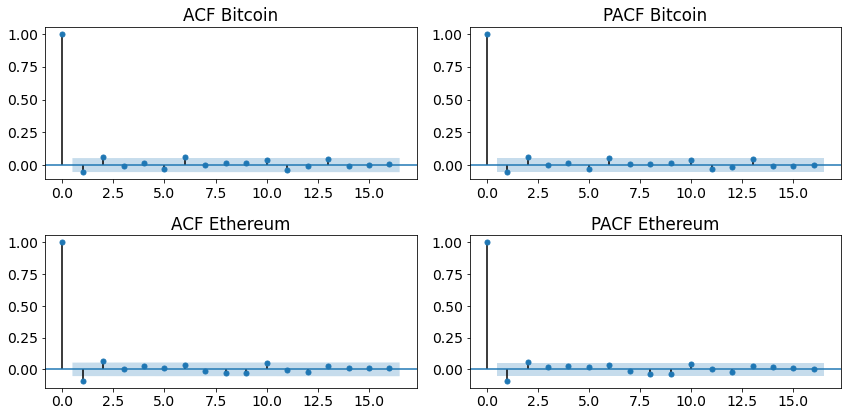

In [32]:
assets_mini = [1, 6]
# Visualize
f, ax = plt.subplots(nrows=len(assets_mini), ncols=2, figsize=(12, len(assets_mini)*3))
for i, asset_id in enumerate(assets_mini):
    plot_acf(train_daily[('lret', i)].fillna(0), lags=16, ax=ax[i, 0], title=f"ACF {asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}")
    plot_pacf(train_daily[('lret', i)].fillna(0), lags=16, method='ols', ax=ax[i, 1], title=f"PACF {asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}")
    
plt.tight_layout()
plt.show()

**Determining Trend with Moving Average Plot**

In [33]:
for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('lret -1',  asset_id)] = train_daily[('lret',  asset_id)].shift(1)

In [35]:
!pip install -U statsmodels

     |████████████████████████████████| 9.8 MB 5.4 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


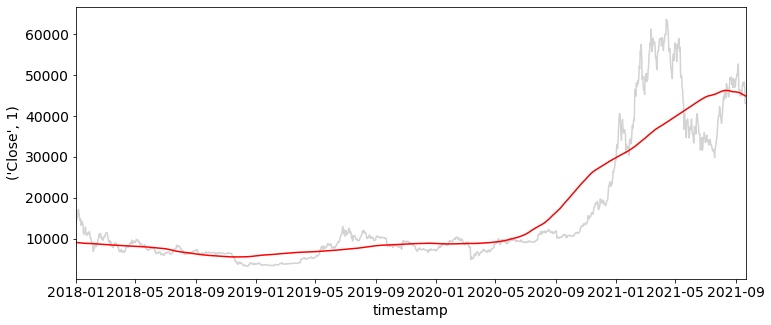

In [37]:
trend = train_daily[('Close',  1)].rolling(
    window=365,       # 365-day window
    center=True,      # puts the average at the center of the window
    min_periods=183,  # choose about half the window size
).mean()   

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(12,5))

sns.lineplot(data=train_daily, x='timestamp', y = ('Close',  1) , ax=ax, color='lightgrey');
sns.lineplot(x=train_daily['timestamp'], y = trend, ax=ax, color='red');
#ax[i].set_title(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]} Trend with a Period of {p} Day")
ax.set_xlim([train_daily.timestamp.iloc[0], train_daily.timestamp.iloc[-1]])
#ax[i].set_ylabel('Close Price [$]')

#plt.suptitle(f'Underlying Trend with {PERIOD} day period\n')
plt.show()

**Seasonality**

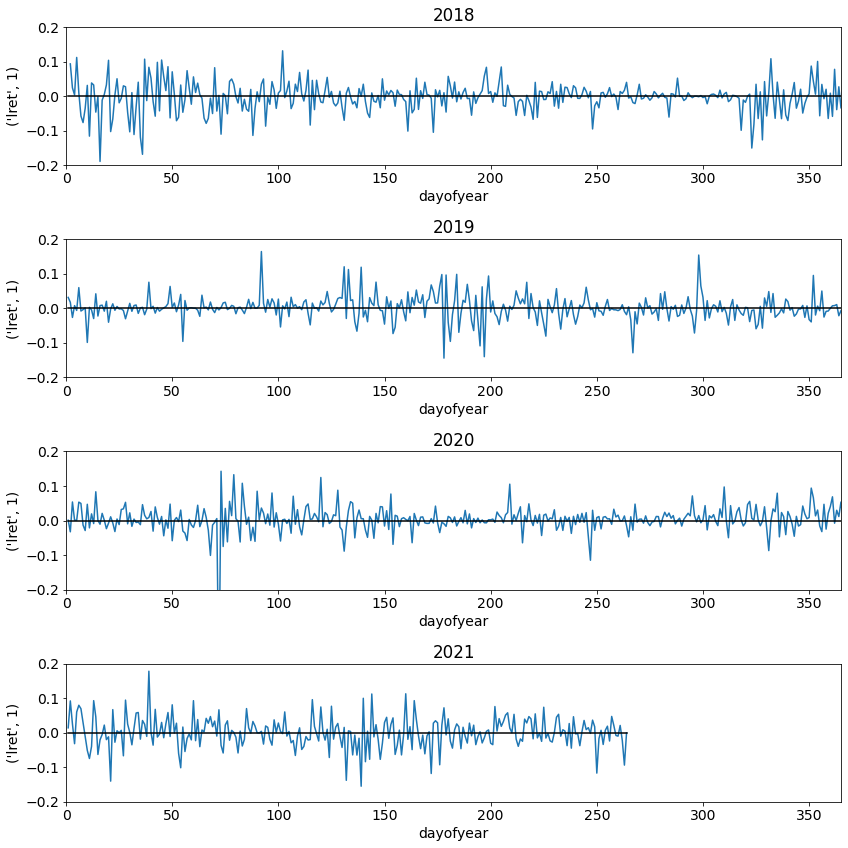

In [38]:
# Visualize
f, ax = plt.subplots(nrows=len(train_daily.year.unique()), ncols=1, figsize=(12, 12))
for i, year in enumerate(train_daily.year.unique()):

    sns.lineplot(data=train_daily[train_daily.year == year], x='dayofyear', y = ('lret',  1), ax=ax[i])
    sns.lineplot(data=train_daily[train_daily.year == year], x='dayofyear', y = 0 , ax=ax[i], color='black');

    ax[i].set_title(year)
    ax[i].set_xlim([0, 365])
    ax[i].set_ylim([-.2, .2])

plt.tight_layout()
plt.show()

In [39]:
# https://www.kaggle.com/ryanholbrook/seasonality

# annotations: https://stackoverflow.com/a/49238256/5769929
def seasonal_plot(X, y, period, freq, ax=None):
    if ax is None:
        _, ax = plt.subplots()
    palette = sns.color_palette("husl", n_colors=X[period].nunique(),)
    ax = sns.lineplot(
        x=freq,
        y=y,
        hue=period,
        data=X,
        ci=False,
        ax=ax,
        palette=palette,
        legend=False,
    )
    ax.set_title(f"Seasonal Plot ({period}/{freq})")
    for line, name in zip(ax.lines, X[period].unique()):
        y_ = line.get_ydata()[-1]
        ax.annotate(
            name,
            xy=(1, y_),
            xytext=(6, 0),
            color=line.get_color(),
            xycoords=ax.get_yaxis_transform(),
            textcoords="offset points",
            size=14,
            va="center",
        )
    return ax


def plot_periodogram(ts, detrend='linear', ax=None):
    from scipy.signal import periodogram
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

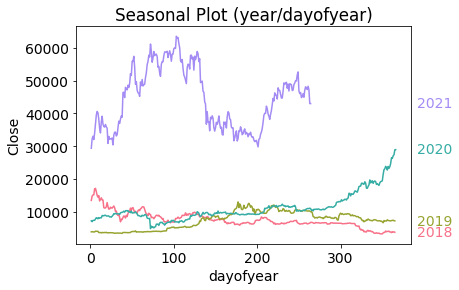

In [40]:
X = train_daily[[('Close', 1), ('dayofyear', ''), ('year', '')]]
X.columns = X.columns.get_level_values(0)

seasonal_plot(X, y='Close', period='year', freq='dayofyear');

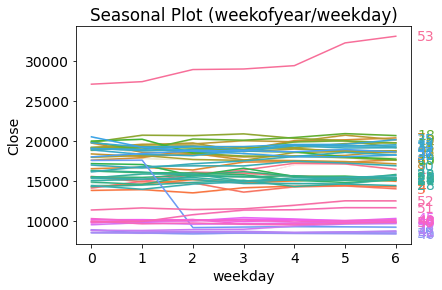

In [41]:
X = train_daily[[('Close', 1), ('weekday', ''), ('weekofyear', '')]]
X.columns = X.columns.get_level_values(0)

seasonal_plot(X, y='Close', period='weekofyear', freq='weekday');

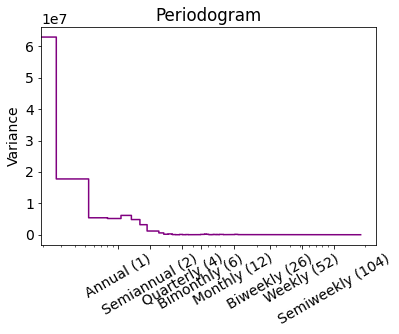

In [42]:
X = train_daily.set_index('timestamp')[('Close', 1)]

plot_periodogram(X);

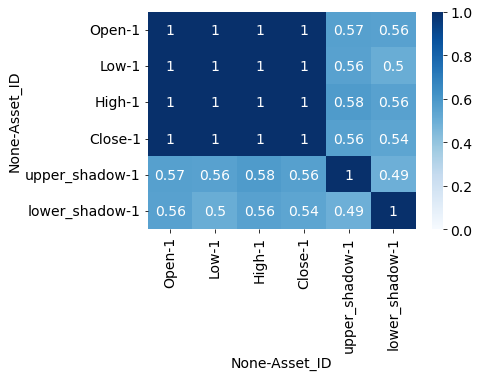

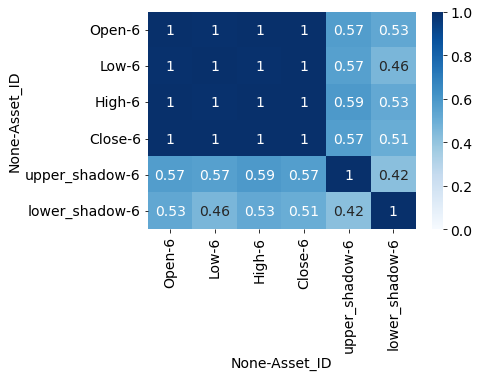

In [43]:
# Upper Shadow and Lower Shadow as shown in the [Tutorial to the G-Research Crypto Competition](https://www.kaggle.com/cstein06/tutorial-to-the-g-research-crypto-competition)

for i, asset_id in enumerate(asset_details.Asset_ID):
    train_daily[('upper_shadow',  asset_id)] = train_daily[('High',  asset_id)] - np.maximum(train_daily[('Close',  asset_id)], train_daily[('Open',  asset_id)])
    train_daily[('lower_shadow',  asset_id)] = np.minimum(train_daily[('Close',  asset_id)], train_daily[('Open',  asset_id)]) - train_daily[('Low',  asset_id)]
    
asset_id = 1

temp = train_daily[[('Open',  asset_id), ('Low',  asset_id), ('High',  asset_id), ('Close',  asset_id), ('upper_shadow',  asset_id), ('lower_shadow',  asset_id)]]
sns.heatmap(temp.corr(), vmin=0, vmax=1, cmap='Blues', annot=True)
plt.show()

asset_id = 6

temp = train_daily[[('Open',  asset_id), ('Low',  asset_id), ('High',  asset_id), ('Close',  asset_id), ('upper_shadow',  asset_id), ('lower_shadow',  asset_id)]]
sns.heatmap(temp.corr(), vmin=0, vmax=1, cmap='Blues', annot=True)
plt.show()

In [44]:
## Stationarity

#The 'Close' prices seem to be mostly non-stationary. However, Bitcoin and Ethereum seem to be stationary.

from statsmodels.tsa.stattools import adfuller

def check_stationarity(series, asset_id):
    # Copied and edited from https://machinelearningmastery.com/time-series-data-stationary-python/

    result = adfuller(series.values)
    if (result[1] <= 0.05) & (result[4]['5%'] > result[0]):
        print(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}: \u001b[32mStationary\u001b[0m")
    else:
        print(f"{asset_details[asset_details.Asset_ID == asset_id].Asset_Name.values[0]}: \x1b[31mNon-stationary\x1b[0m")
       
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    print('\n')

assets_mini = [1, 6, 9, 4]
for i, asset_id in enumerate(assets_mini):    
    check_stationarity(train_daily[('Close', i)].fillna(0), asset_id)
    
    
    
# The log returns seem to be stationary.
for i, asset_id in enumerate(assets_mini):    
    check_stationarity(train_daily[('lret', i)].fillna(0), asset_id)

Bitcoin: Non-stationary
ADF Statistic: -1.159645
p-value: 0.690710
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Ethereum: Non-stationary
ADF Statistic: -0.422392
p-value: 0.906293
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Litecoin: Stationary
ADF Statistic: -4.032213
p-value: 0.001251
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Dogecoin: Non-stationary
ADF Statistic: -0.587023
p-value: 0.873887
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Bitcoin: Stationary
ADF Statistic: -10.675228
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Ethereum: Stationary
ADF Statistic: -25.601031
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Litecoin: Stationary
ADF Statistic: -16.586814
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


Dogecoin: Stationary
ADF Statistic: -16.980850
p-value: 0.000000
Critical Values:
	1%: -3.435
	5%: -2.864
	10%: -2.568


